In [ ]:
!pip install kaggle

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error

In [ ]:
!mkdir -p /root/.kaggle/

In [ ]:
ls -la /root/

total 72
drwx------ 1 root root 4096 Jan 17 20:08 ./
drwxr-xr-x 1 root root 4096 Jan 17 19:59 ../
-r-xr-xr-x 1 root root 1220 Jan  1  2000 .bashrc*
drwxr-xr-x 1 root root 4096 Jan 16 14:40 .cache/
drwxr-xr-x 1 root root 4096 Jan 16 14:40 .config/
drwxr-xr-x 5 root root 4096 Jan 16 14:39 .ipython/
drwx------ 1 root root 4096 Jan 16 14:39 .jupyter/
drwxr-xr-x 2 root root 4096 Jan 17 20:08 .kaggle/
drwxr-xr-x 2 root root 4096 Jan 17 20:00 .keras/
drwx------ 3 root root 4096 Jan 16 14:20 .launchpadlib/
drwxr-xr-x 1 root root 4096 Jan 16 14:39 .local/
drwxr-xr-x 4 root root 4096 Jan 16 14:39 .npm/
-rw-r--r-- 1 root root  161 Jul  9  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf*
-rw-r--r-- 1 root root  211 Jan 16 14:39 .wget-hsts


In [ ]:
!echo '{"username":"anushrivhanmane","key":"612de01b984423da963b11d214b608cb"}' > /root/.kaggle/kaggle.json

In [ ]:
!cat /root/.kaggle/kaggle.json

{"username":"anushrivhanmane","key":"612de01b984423da963b11d214b608cb"}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d steubk/WikiArt

Dataset URL: https://www.kaggle.com/datasets/steubk/WikiArt
License(s): CC0-1.0
100% 31.3G/31.4G [02:57<00:00, 230MB/s]
100% 31.4G/31.4G [02:57<00:00, 190MB/s]


In [ ]:
!unzip /content/WikiArt.zip

Streaming output truncated to the last 5000 lines.
  inflating: Symbolism/henri-fantin-latour_the-three-rhine-maidens-1876.jpg  
  inflating: Symbolism/henri-fantin-latour_to-robert-schumann.jpg  
  inflating: Symbolism/henri-fantin-latour_truth-1891.jpg  
  inflating: Symbolism/henri-fantin-latour_two-bathers.jpg  
  inflating: Symbolism/henri-fantin-latour_undine.jpg  
  inflating: Symbolism/henri-fantin-latour_venus-and-cupid-1902.jpg  
  inflating: Symbolism/henri-fantin-latour_woman-at-her-toillette-1898.jpg  
  inflating: Symbolism/henri-martin_lady-with-lyre-by-pine-trees-1890.jpg  
  inflating: Symbolism/henri-martin_muse-in-the-fields.jpg  
  inflating: Symbolism/henri-martin_muse.jpg  
  inflating: Symbolism/henri-martin_mystic-scene-1895.jpg  
  inflating: Symbolism/henri-martin_orpheus-in-a-wood-1895.jpg  
  inflating: Symbolism/henri-martin_orpheus-returns-from-the-pursuit-of-eurydice.jpg  
  inflating: Symbolism/henri-martin_orpheus.jpg  
  inflating: Symbolism/henri-mart

In [ ]:
class TwoFolderDataset:
    def __init__(self, content_dir, style_dir, transform=None):
        self.content_images = [os.path.join(content_dir, img) for img in os.listdir(content_dir) if img.endswith(('.jpg', '.png'))]
        self.style_images = [os.path.join(style_dir, img) for img in os.listdir(style_dir) if img.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return min(len(self.content_images), len(self.style_images))

    def __getitem__(self, idx):
        content_path = self.content_images[idx]
        style_path = self.style_images[idx]
        content_image = Image.open(content_path).convert("RGB")
        style_image = Image.open(style_path).convert("RGB")
        if self.transform:
            content_image = self.transform(content_image)
            style_image = self.transform(style_image)
        return content_image, style_image

In [ ]:
# Fast Neural Style Transfer Model
class FastStyleTransfer(nn.Module):
    def __init__(self):
        super(FastStyleTransfer, self).__init__()
        # Encoder (VGG19 up to relu4_1)
        self.encoder = nn.Sequential(*list(models.vgg19(pretrained=True).features[:21]))
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, 3, padding=1)
        )
        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, content, style):
        # Extract features
        content_features = self.encoder(content)
        style_features = self.encoder(style)
        # Match content and style features
        t = self.adain(content_features, style_features)
        # Decode to generate the stylized image
        return self.decoder(t)

    @staticmethod
    def adain(content_features, style_features):
        content_mean, content_std = FastStyleTransfer.calc_mean_std(content_features)
        style_mean, style_std = FastStyleTransfer.calc_mean_std(style_features)
        normalized_features = (content_features - content_mean) / content_std
        return normalized_features * style_std + style_mean

    @staticmethod
    def calc_mean_std(features, eps=1e-5):
        size = features.size()
        N, C = size[:2]
        feat_var = features.view(N, C, -1).var(dim=2, unbiased=False) + eps
        feat_std = feat_var.sqrt().view(N, C, 1, 1)
        feat_mean = features.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
        return feat_mean, feat_std

In [ ]:
# Gram Matrix Calculation for Style Loss
def gram_matrix(features):
    N, C, H, W = features.size()
    features = features.view(N, C, H * W)
    return torch.bmm(features, features.transpose(1, 2)) / (C * H * W)

In [ ]:
# Visualize Sample Images
def visualize_images(loader, title="Content and Style Samples"):
    content_images, style_images = next(iter(loader))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axes[0, i].imshow((content_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1))
        axes[0, i].axis("off")
        axes[0, i].set_title("Content")

        axes[1, i].imshow((style_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1))
        axes[1, i].axis("off")
        axes[1, i].set_title("Style")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Training Loop
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for content, style in loader:
        content, style = content.to(device), style.to(device)

        # Forward pass
        stylized_output = model(content, style)

        # Compute content loss (using original content as supervision)
        loss = criterion(stylized_output, content)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
# Visualize Stylized Output
def visualize_stylized_output(model, loader, device):
    model.eval()
    content_images, style_images = next(iter(loader))
    content_images, style_images = content_images.to(device), style_images.to(device)
    with torch.no_grad():
        outputs = model(content_images, style_images)
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow((content_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
        axes[0, i].axis("off")
        axes[0, i].set_title("Content")

        axes[1, i].imshow((style_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
        axes[1, i].axis("off")
        axes[1, i].set_title("Style")

        axes[2, i].imshow((outputs[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
        axes[2, i].axis("off")
        axes[2, i].set_title("Stylized")
    plt.tight_layout()
    plt.show()

In [ ]:
# Main Script
def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    content_dir = "/content/Realism"
    style_dir = "/content/Abstract_Expressionism"

    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
    ])

    dataset = TwoFolderDataset(content_dir, style_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

    # Step 1: Visualize Images
    visualize_images(train_loader, "Sample Content and Style Images")

    # Initialize Model, Optimizer, and Criterion
    model = FastStyleTransfer().to(device)
    optimizer = optim.Adam(model.decoder.parameters(), lr=1e-4)
    criterion = nn.MSELoss()  # Content-based loss

    # Train Model
    print("Training the model...")
    for epoch in range(10):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

    # Visualize Stylized Output
    visualize_stylized_output(model, val_loader, device)

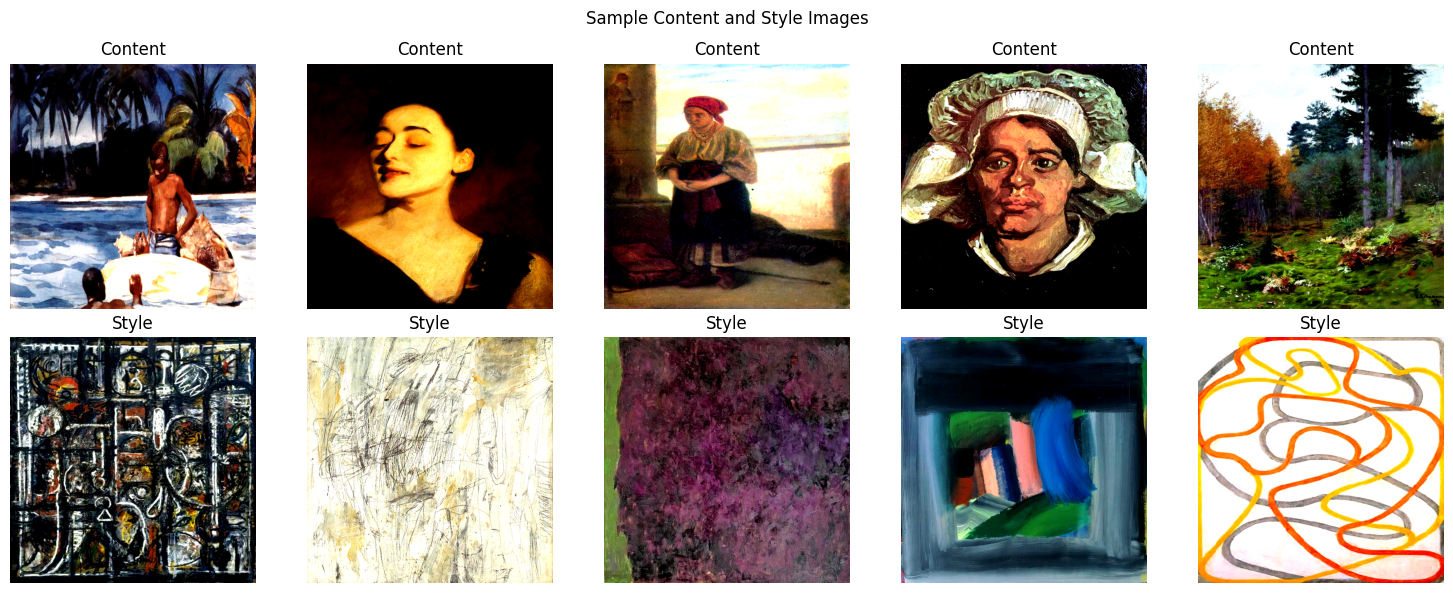

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 199MB/s]


Training the model...
Epoch 1, Loss: 0.5131
Epoch 2, Loss: 0.3191
Epoch 3, Loss: 0.2481
Epoch 4, Loss: 0.2178
Epoch 5, Loss: 0.1981
Epoch 6, Loss: 0.1857
Epoch 7, Loss: 0.1736
Epoch 8, Loss: 0.1676
Epoch 9, Loss: 0.1611
Epoch 10, Loss: 0.1565


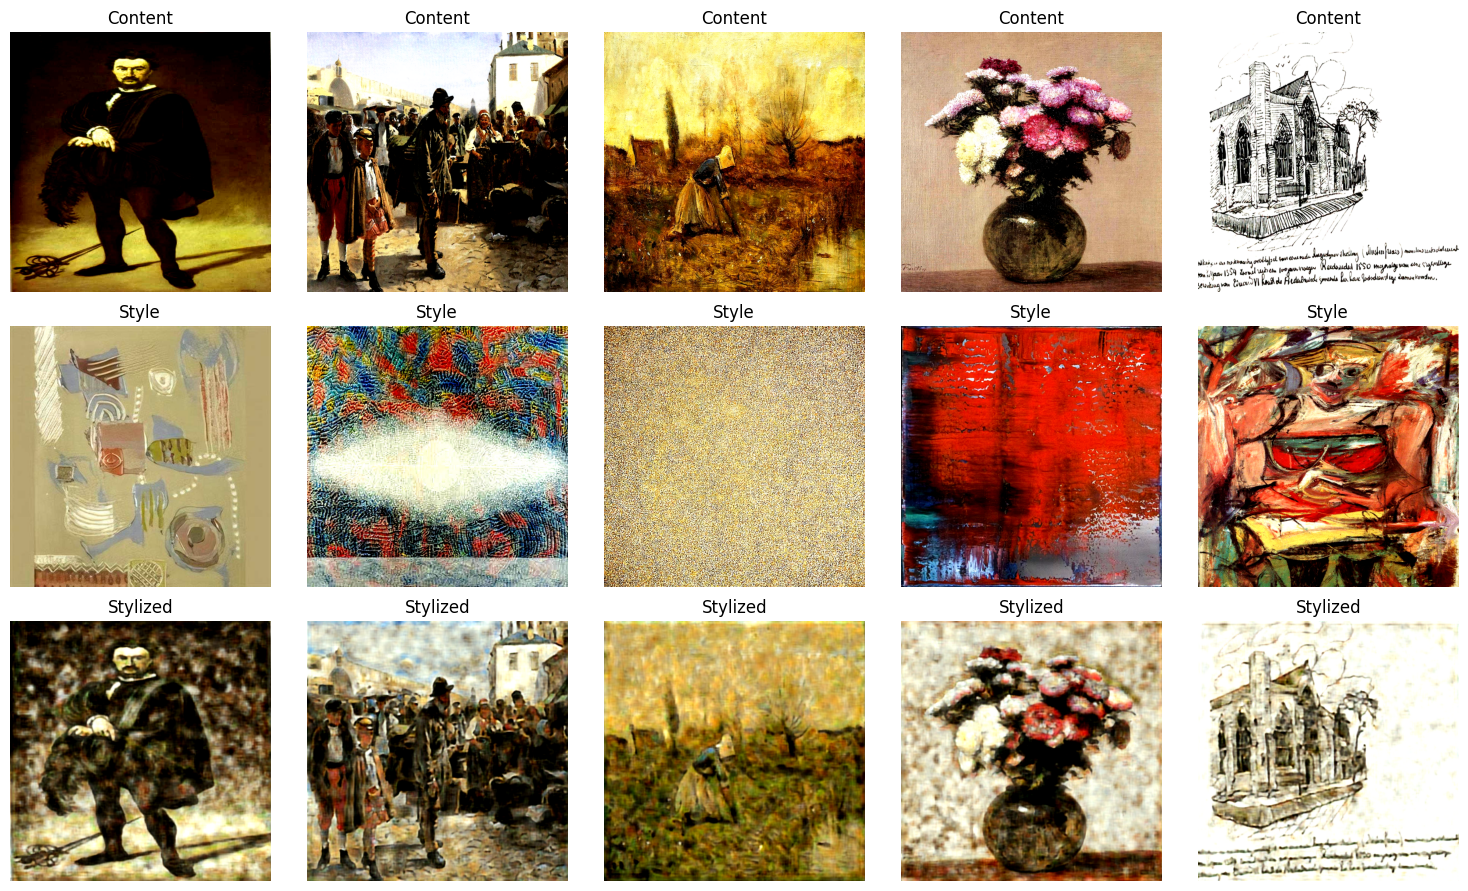

In [ ]:
# Load data
if __name__ == "__main__":
    main()